# Recunoașterea de cuvinte scurte

În acest proiect procesez semnale audio în format waw. Totodata construiesc și  antrenez un model de bază de recunoaștere automată a vorbirii (ASR) pentru recunoașterea a zece cuvinte diferite.

# > Aceste cuvinte sunt: "no", "yes", "stop", "left", "right", "go", "down", "up".




## Să începem:
# Import modulele și dependențele necesare

Instalare module necesare

In [1]:
!pip install -U -q tensorflow==2.15.0  # am pus 2.15.0 pentru a avea o versiune compatibila
!pip install tensorflow_datasets==4.9.4 -q


In [2]:
!pip install librosa  -q # etse o librarie utilizata pentru analiza si procesarea sunteului si muzicii

Instalare librării

In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Conectare cu google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Clipurile audio ale setului de date sunt stocate în opt foldere corespunzătoare fiecărei comenzi vocale: **no, yes, down, go, left, up, right, and stop.**

In [5]:
data_dir ='/content/drive/MyDrive/PSV/mini_speech_commands' # calea spre directorul unde am cele 8 clase din google drive
commands = np.array(tf.io.gfile.listdir(str(data_dir)))     #returneaza o lista cu numele fisierelor din directorul stocat
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]  #README este un fisier text care contine informatii introductive despre continutul directoarelor si
                                                                            #nu este relevant pentru ceea ce imi doresc eu sa afisez, acesta poate contine informatii despre o anumita licienta sau asistenta
                                                                            #DS_STORE este un fisier ascuns creeat de macOS pentru a stoca difeirte informatii, cum ar fi pozitia pictogramelor sau imagini
print('Commands:', commands)                               #afisez lista cu comenzi

Commands: ['right' 'no' 'yes' 'left' 'down' 'up' 'stop' 'go']


# Prelucrare set de date

## Împart inregistrarile în subdirectoare

> Clipurile audio durează 1 secundă sau mai puțin la 16 kHz. Output_sequence_length=16000 le acoperă pe cele scurte la exact 1 secundă (și le-ar tăia pe cele mai lungi), astfel încât să poată fi grupate cu ușurință.\
Pentru **antrenare** foloses **80%** din date, iar pentru **validare și testare 20%**.







## Aflu cate elemente sunt in testul de antrenare, si cate in cel de testare:

In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(  #importa modulul keras.untils si imparte datele in train_ds pentru antrenare si val_ds pentru validare si testare
    directory=data_dir,  #se atribuie calea unde sunt stocate fisierele
    batch_size=64,       #numarul de audio samples per batch(sau pe fereastra)
    validation_split=0.2, #20% dintre date sunt folosite pentru validare
    seed=0,               #numar intreg utilizat pentru initializarea generatorului de numere aleatoare atunci cand amesteca datele
    output_sequence_length=16000, #lungimea maxima in esantioane, la care secventele audio vor fi completate sau trunchiaite
    subset='both')       #Returneaza ambele seturi de date atat de antrenare cat si de validare



label_names = np.array(train_ds.class_names)  #extrage numele claselor din setul de date de antrenament
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


## O altă modalitate de a vedea cate date sunt împărțite în antrenare și testare.



Funcția "glob" din TensorFlow I/O : pentu a căuta toate fișierele din directorul dat, precum și din toate subdirectoarele sale. Rezultatul este o listă de nume de fișiere.

filtram această listă pentru a include doar fișierele care conțin cuvântul "wav" în numele lor, folosind o listă de comprehensiune.

Se amestecă aleator lista rezultată, folosind funcția "shuffle" din TensorFlow.

Se calculează numărul total de exemple din lista de fișiere și se afișează

In [7]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = [filename for filename in filenames if 'wav' in filename]
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Numarul total de fisiere audio:', num_samples)
print('Numarul de fisiere audio per label:', len(tf.io.gfile.listdir(str(data_dir + '/' + label_names[0])))) #label= director
print('Tensorul unui fisier exemplu:', filenames[0])

Numarul total de fisiere audio: 8000
Numarul de fisiere audio per label: 1000
Tensorul unui fisier exemplu: tf.Tensor(b'/content/drive/MyDrive/PSV/mini_speech_commands/up/6cb6eee7_nohash_1.wav', shape=(), dtype=string)


In [8]:
TRAIN_SIZE = 0.8

train_files = filenames[:int(len(filenames) * TRAIN_SIZE)]                         # 0 -> 6400 :  set de antrenare
val_files = filenames[int(len(filenames) * TRAIN_SIZE):int(len(filenames)*0.875)]  # 6401 -> 7000 : set de validare => 600 fisiere audio
test_files = filenames[int(len(filenames)*0.875):]                                 # 7001 -> 8000 set de test => 1000

print('Dimensiunea setului de antrenare:', len(train_files))
print('Dimensiunea setului de validare:', len(val_files))
print('Dimensiunea setului de test:', len(test_files))

Dimensiunea setului de antrenare: 6400
Dimensiunea setului de validare: 600
Dimensiunea setului de test: 1000


Prin "element_spec" returneaz" un tuplu care descrie tipul și forma elementelor din setul de date.

In [9]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [10]:
train_files

<tf.Tensor: shape=(6400,), dtype=string, numpy=
array([b'/content/drive/MyDrive/PSV/mini_speech_commands/up/6cb6eee7_nohash_1.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/right/09bcdc9d_nohash_0.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/up/19b05529_nohash_1.wav',
       ...,
       b'/content/drive/MyDrive/PSV/mini_speech_commands/no/35d1b6ee_nohash_2.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/yes/da5dadb9_nohash_1.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/go/87c62767_nohash_1.wav'],
      dtype=object)>

In [11]:
val_files

<tf.Tensor: shape=(600,), dtype=string, numpy=
array([b'/content/drive/MyDrive/PSV/mini_speech_commands/go/ffd2ba2f_nohash_2.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/up/7f17667c_nohash_0.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/right/9d4bab4f_nohash_0.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/stop/5fc3ed24_nohash_2.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/up/c08585c1_nohash_0.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/yes/229978fd_nohash_0.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/stop/742d6431_nohash_3.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/up/c727b558_nohash_0.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/stop/e41a903b_nohash_2.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/up/493392c6_nohash_1.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/stop/96a48d28_nohash_2.wav',
       b'/content

In [12]:
test_files

<tf.Tensor: shape=(1000,), dtype=string, numpy=
array([b'/content/drive/MyDrive/PSV/mini_speech_commands/yes/7799c9cd_nohash_0.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/up/92a9c5e6_nohash_2.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/stop/77655bdf_nohash_0.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/up/4cb874bb_nohash_0.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/yes/9ff2d2f4_nohash_0.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/down/b8872c20_nohash_0.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/right/e652590d_nohash_1.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/stop/aff582a1_nohash_4.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/left/4f2be90f_nohash_0.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/right/9ff2d2f4_nohash_2.wav',
       b'/content/drive/MyDrive/PSV/mini_speech_commands/right/418e7158_nohash_4.wav',
       b'

Acest set de date conține doar un singur canal audio, așa că utilizez funcția **tf.squeeze** pentru a renunța la axa suplimentară. Eliminarea axei redundante poate îmbunătăți performanța modelului, deoarece modelul nu trebuie să proceseze informații inutile.

 Această secțiune definește o funcție numită squeeze care acceptă doi argumente: audio și labels.

**audio:** Tensorul care conține datele audio.\
**labels:** Tensorul care conține etichetele claselor pentru datele audio.

**audio = tf.squeeze(audio, axis=-1)**: Această linie utilizează funcția tf.squeeze pentru a reduce dimensiunea tensorului audio de-a lungul axei -1 (ultima axă).

In [13]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels   # returnează atât tensorul audio modificat (audio) cât și tensorul etichetelor (labels) nemodificat

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Împart setul de date în 2 seturi, unul de testare și unul de validare.

In [14]:
test_ds = val_ds.shard(num_shards=2, index=0)  #shard=fragmentare num_sgard=2, reprezinta numarul de fragmente, index=0, reprezinta prima parte din set
val_ds = val_ds.shard(num_shards=2, index=1)   #index=1, reprezinta a 2 a parte din set


Reprezint câteva forme de undă audio

In [15]:
label_names[[1,2,0,7]]  #extrag elementele din lista, aflate pe pozitiile indicate de indici

array(['go', 'left', 'down', 'yes'], dtype='<U5')

In [16]:
for example_audio, example_labels in train_ds.take(1): # Acest cod preiază un singur element (exemplu) din setul de date de antrenament (train_ds)
                                                        # și îi afișează forma datelor audio și etichetelor corespondente.
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


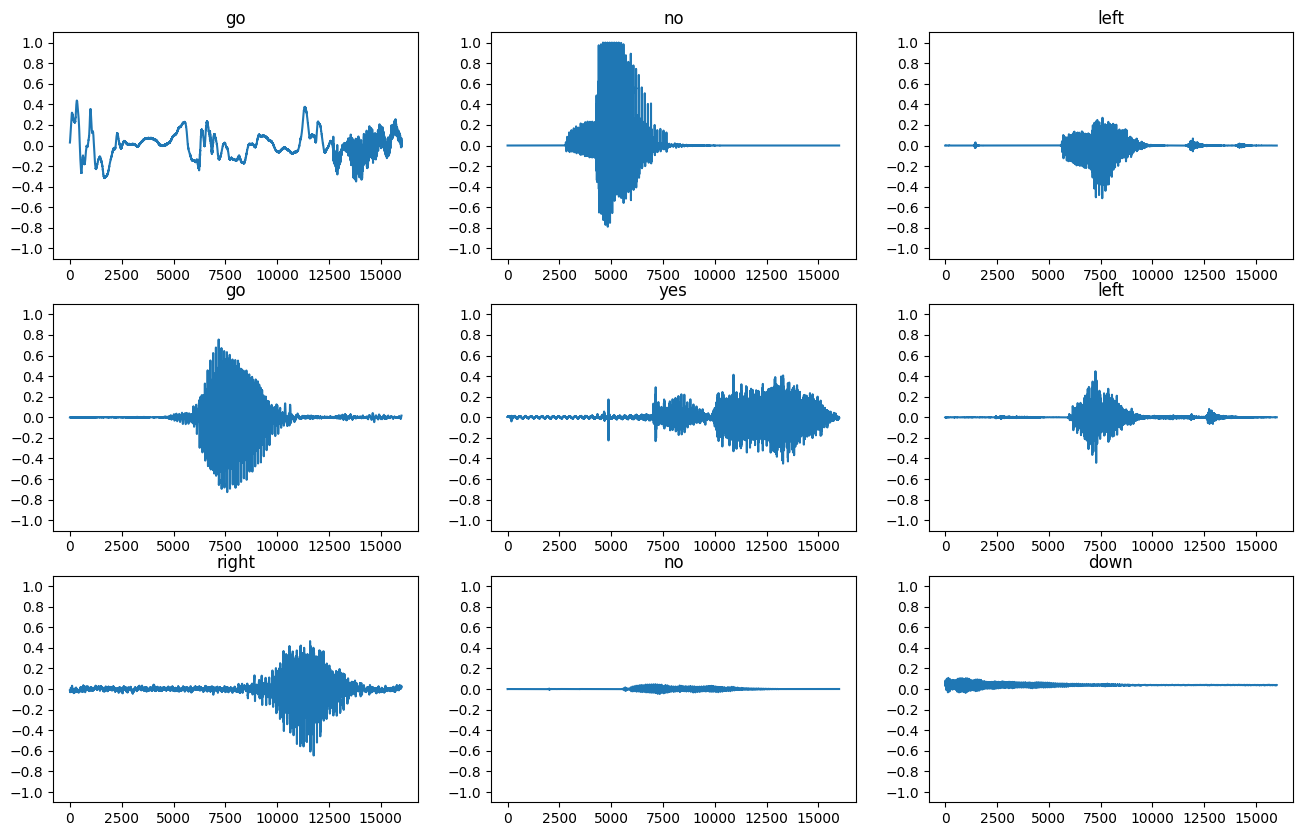

In [17]:
plt.figure(figsize=(16, 10)) # creeaza o figura de 16 inch pe 10 inch
rows=3
cols=3
n = rows * cols   # 3 rqanduri , # coloane de unde rezulta 9 subploturi
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)     # Trasează semnalul audio extras pe subplotul curent.
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))  #Setează etichetele pentru axa Y (verticală) cu valori cuprinse între -1.2 și 1.2 la intervale de 0.2
  plt.ylim([-1.1, 1.1])    #Setează limita axei Y între -1.1 și 1.1 pentru a asigura o scalare corespunzătoare a semnalului audio

## Convertesc formele de undă în spectogramă

Formele de undă din setul de date sunt reprezentate în domeniul timp. În continuare, voi transforma formele de undă din semnalele in domeniul timpului în semnale in domeniului frecvenței, calculând [transformata Fourier pe timp scurt (STFT)](https://en.wikipedia.org/wiki/Short- time_Fourier_transform) pentru a converti formele de undă în spectrograme(https://en.wikipedia.org/wiki/Spectrogram), care arată modificări de frecvență în timp și pot fi reprezentate ca imagini 2D. Voi alimenta imaginile spectrogramei în rețeaua neuronală pentru a antrena modelul.

O transformată Fourier (`tf.signal.fft`) convertește un semnal la frecvențele sale componente, dar pierde toate informațiile de timp. În comparație, STFT (`tf.signal.stft`) împarte semnalul în ferestre de timp și rulează o transformare Fourier pe fiecare fereastră, păstrând unele informații de timp și returnând un tensor 2D.

Creez o funcție de utilitate pentru conversia formelor de undă în spectrograme:

- Formele de undă trebuie să fie de aceeași lungime, astfel încât atunci când le convertesc în spectrograme, rezultatele să aibă dimensiuni similare. Acest lucru se poate face pur și simplu prin zero-padding clipurile audio care sunt mai scurte de o secundă (folosind `tf.zeros`).
- Când apelez `tf.signal.stft`, aleg parametrii `frame_length` și `frame_step` astfel încât „imaginea” spectrograma generată să fie aproape pătrată.
- STFT produce o serie de numere complexe reprezentând magnitudinea și faza. Cu toate acestea, în acest proiect voi folosi doar magnitudinea, pe care o obțin prin aplicarea `tf.abs` la ieșirea lui `tf.signal.stft`.

In [18]:
def get_spectrogram(waveform):
  # Convertesc forma de undă într-o spectrogramă printr-un STFT
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obțineți magnitudinea STFT.   Transformarea Fourier pe timp scurt (STFT)
  spectrogram = tf.abs(spectrogram)

  spectrogram = spectrogram[..., tf.newaxis]   # adauga o noua dimensiune la final, pentru a marca ca s a terminat spectrograma
  return spectrogram

Afișez formele de undă tensorizate a unui exemplu și spectrograma corespunzătoare și redau semnalul audio original:

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


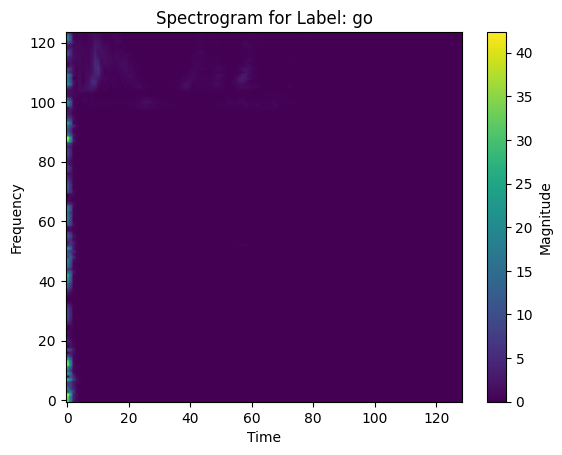

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


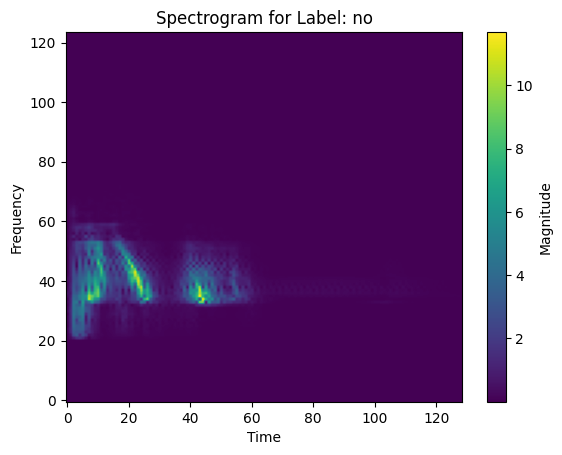

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


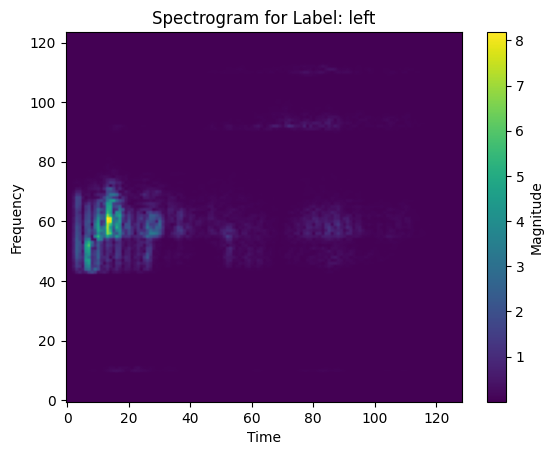

In [19]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

  # Plot the spectrogram
  plt.imshow(spectrogram, aspect='auto', origin='lower')  # Corrected indentation
  plt.title(f'Spectrogram for Label: {label}')
  plt.xlabel('Time')
  plt.ylabel('Frequency')
  plt.colorbar(label='Magnitude')
  plt.show()


Definesc o funcție pentru afișarea spectogramelor

In [20]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:    # verific daca spectrograma are mai mult de 2 dimensiuni
    assert len(spectrogram.shape) == 3  # daca da verific, daca este==3, adica daca este in spatiul 3D
    spectrogram = np.squeeze(spectrogram, axis=-1)  # daca a 3a dimensiune are valoare 1 o elimin cu np.squeeze
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)  #realizez o transformare logaritmica, a spectrogramei transpuse , am adaugat np,finfo(float). eps,
                                                           #deoarece aceasta rep o precizie minima a tipului de date float
  height = log_spec.shape[0]       # extrag dimensiunile din log_spec, care contine valorile indicilor claselor pe care le clasific
  width = log_spec.shape[1]        #shape este o proprietete din NumPy care returneaza un tuplu cu numarul de elemenete a fiecarei dimensiuni
                                  #shape[0] rep inaltimea (nr de linii)
                                  #shape[1] rep latimea ( nr de coloane)
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)  #creez o axa a timpului
  Y = range(height)                                               #creez o axa a frecventei
  ax.pcolormesh(X, Y, log_spec)          # ax.pcolormesh(X, Y, log_spec) utilizează metoda pcolormesh pe axa ax pentru a crea o vizualizare colorată a spectrogramului.

Trasez forma de undă a exemplului în timp și spectrograma corespunzătoare (frecvențe în timp):

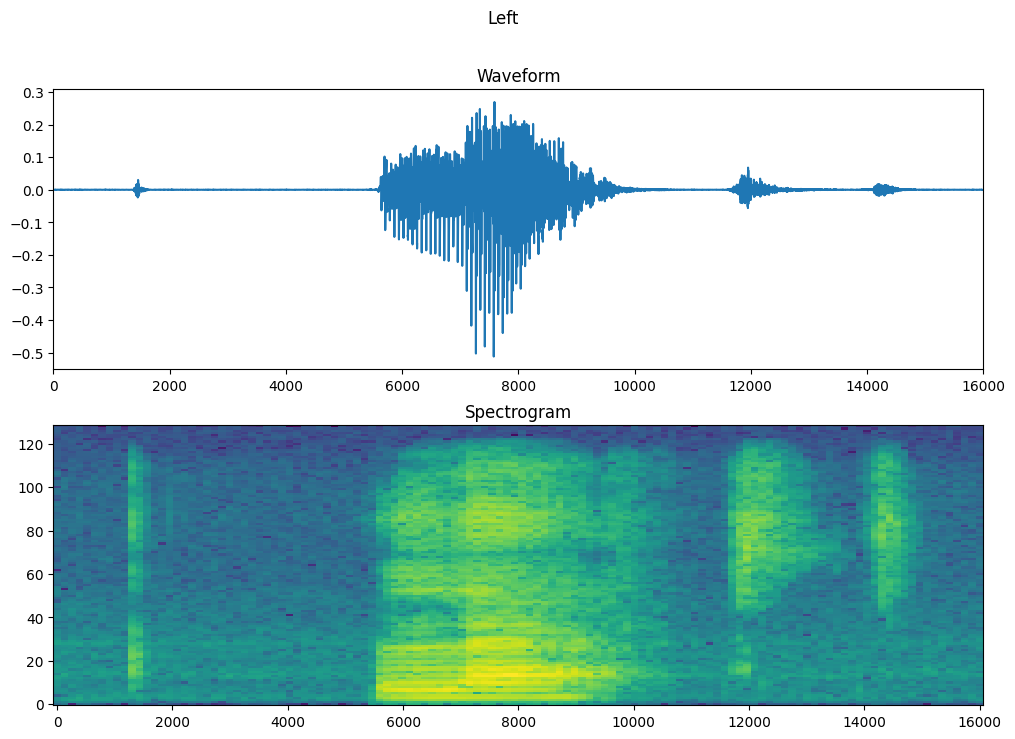

In [21]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Acum creez seturi de date cu spectograme din seturile de date audio de la intrare

In [22]:

#Funcția make_spec_ds transformă un set de date TensorFlow (ds) într-un set de date care conține spectrogramul fiecărui element din setul de date original
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [23]:

#Aceste trei linii de cod creează seturi de date TensorFlow separate pentru antrenament (train), validare (val) și testare (test)
#care conțin spectrogramale ale semnalelor audio din seturile de date originale
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examinez spectrogramele pentru diferite exemple ale setului de date

In [24]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

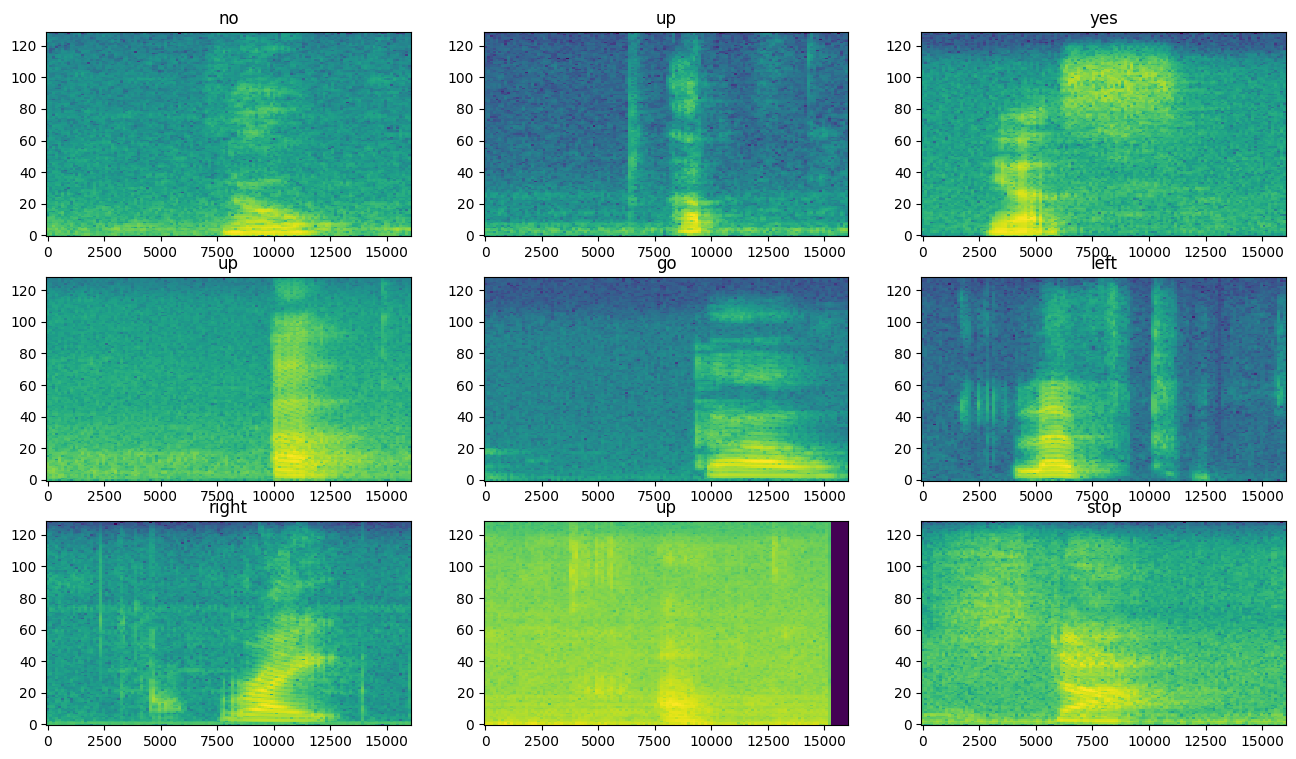

In [25]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Construiesc și antreneaz modelul

Adaug operațiuni `Dataset.cache` și `Dataset.prefetch` pentru a reduce latența de citire în timp ce antrenez modelul:

In [26]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Pentru model, voi folosi o simplă rețea neuronală convoluțională (CNN), deoarece am transformat fișierele audio în imagini de spectrogramă.

Modelul tf.keras.Sequential va folosi următoarele straturi de preprocesare Keras:



*   `tf.keras.layers.Resizing:` pentru a reduce eșantionarea intrării pentru a permite modelului să se antreneze mai rapid.
*   `tf.keras.layers.Normalization`: pentru a normaliza fiecare pixel din imagine pe baza mediei și a deviației standard.Sau altfel spus fiecare pixel să fie cuprins în intervalul [0,1)

Pentru stratul `Normalizare`, metoda sa de adaptare ar trebui mai întâi apelată la datele de antrenament pentru a calcula statistici agregate (adică media și deviatia standard).

In [27]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

Configurez modelul Keras cu optimizatorul Adam și pierderea de entropie încrucișată:

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),                                #optimizatorul
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #functia de pierdere
    metrics=['accuracy'],
)

Antreneaz modelul pe parcursul a 10 epoci în scopuri demonstrative:

In [29]:
EPOCHS = 10
history = model.fit(   #metoda fit e apelata pentru antrenare
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,  #monitorizez performanta modelului in timpul antrenamentului
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),  #monitorizează performanța modelului pe setul de date de validare și oprește antrenamentul anticipat
                                                                        #dacă performanța nu se îmbunătățește pentru un număr specific de epoci consecutive (patience=2).
                                                                        #verbose=1 indică faptul că informații despre oprirea anticipată vor fi tipărite la consolă.
)

Epoch 1/10
100/100 [==============================] - 287s 3s/step - loss: 1.7499 - accuracy: 0.3633 - val_loss: 1.3124 - val_accuracy: 0.5833
Epoch 2/10
100/100 [==============================] - 23s 233ms/step - loss: 1.1748 - accuracy: 0.5841 - val_loss: 0.9062 - val_accuracy: 0.7096
Epoch 3/10
100/100 [==============================] - 25s 248ms/step - loss: 0.8886 - accuracy: 0.6864 - val_loss: 0.7564 - val_accuracy: 0.7643
Epoch 4/10
100/100 [==============================] - 26s 260ms/step - loss: 0.7334 - accuracy: 0.7391 - val_loss: 0.6467 - val_accuracy: 0.8151
Epoch 5/10
100/100 [==============================] - 22s 224ms/step - loss: 0.6312 - accuracy: 0.7730 - val_loss: 0.5847 - val_accuracy: 0.8372
Epoch 6/10
100/100 [==============================] - 24s 241ms/step - loss: 0.5396 - accuracy: 0.8059 - val_loss: 0.5532 - val_accuracy: 0.8307
Epoch 7/10
100/100 [==============================] - 26s 265ms/step - loss: 0.4747 - accuracy: 0.8311 - val_loss: 0.5247 - val_accu

Să trasăm curbele de pierdere de antrenament și validare pentru a verifica cum s-a îmbunătățit modelul în timpul antrenamentului:

Text(0, 0.5, 'Accuracy [%]')

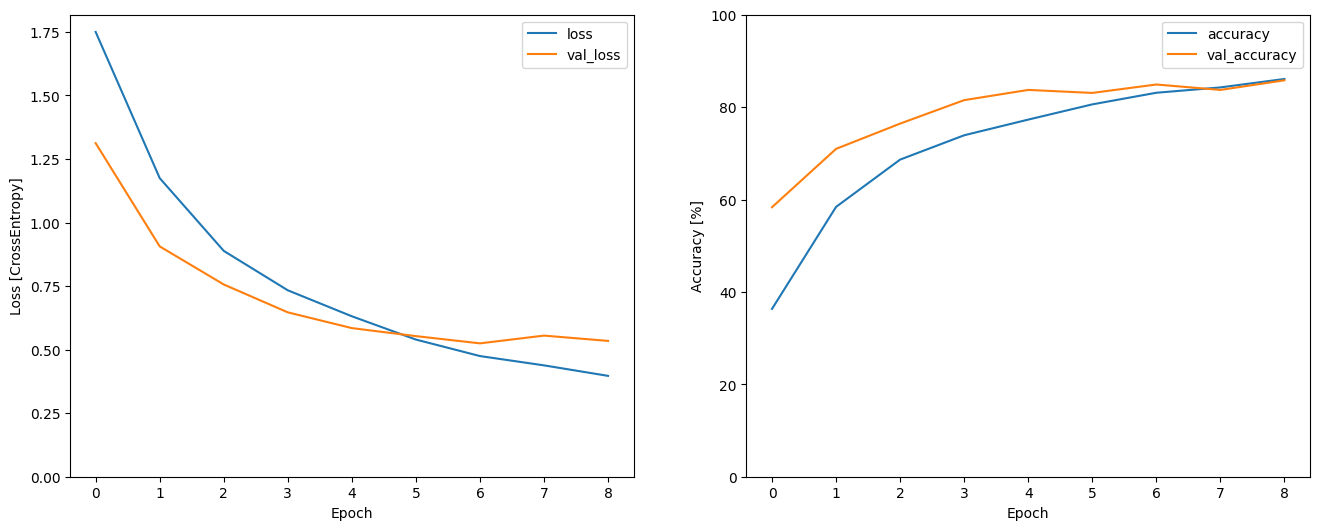

In [30]:
metrics = history.history  #recuperez istoricul de antrenament stocat în variabila history obținută din procesul de antrenament al modelului.
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Prima linie (albastră) arată pierderea din antrenament (metrics['loss']) pe parcursul epocilor.
A doua linie (portocalie) arată pierderea din validare (metrics['val_loss']) pe parcursul epocilor.
La fel este si pentru Acuratețe.

## Evaluez performanța modelului

Rulez modelul pe setul de testare și verific performanța modelului

In [31]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 16s 1s/step - loss: 0.4952 - accuracy: 0.8413


{'loss': 0.4951765835285187, 'accuracy': 0.8413461446762085}

## Afișez o matrice de confuzie

Utilizez o matrice de confuzie pentru a verifica cât de bine am făcut modelul clasificând fiecare dintre comenzile din setul de testare:

In [32]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 1s 49ms/step


In [33]:
y_pred = tf.argmax(y_pred, axis=1)

In [34]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)


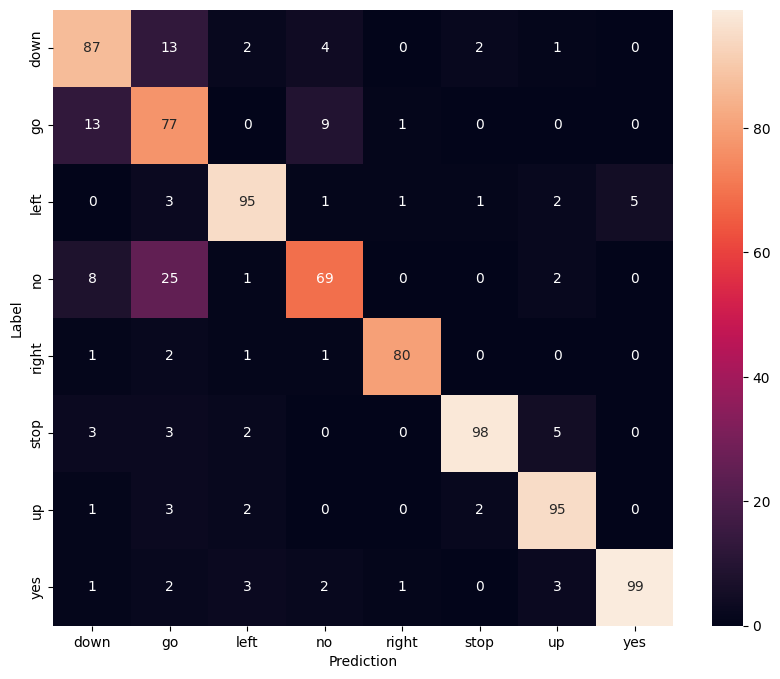

In [35]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Afișez inferența pe un fișier audio

În cele din urmă, verific rezultatul predicției modelului folosind un fișier audio de intrare al cuiva care spune „nu”. Astfel verific cât de bine funcționează modelul

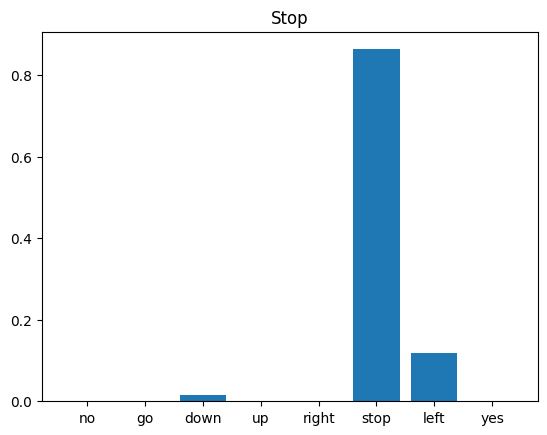

In [66]:
x ='/content/drive/MyDrive/PSV/mini_speech_commands/stop/ffd2ba2f_nohash_4.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'go', 'down', 'up', 'right', 'stop', 'left', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Stop')
plt.show()

display.display(display.Audio(waveform, rate=16000))

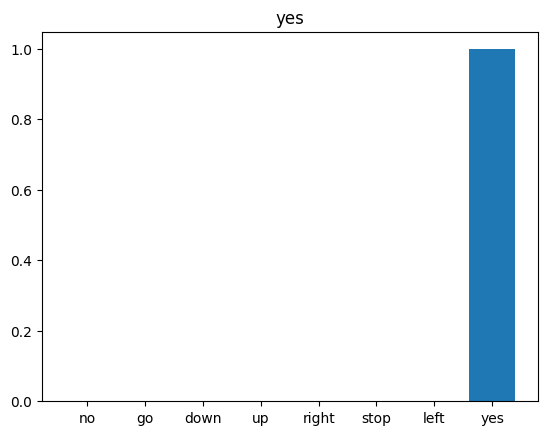

In [65]:
x ='/content/drive/MyDrive/PSV/mini_speech_commands/yes/ffd2ba2f_nohash_2.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels =  ['no', 'go', 'down', 'up', 'right', 'stop', 'left', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('yes')
plt.show()

display.display(display.Audio(waveform, rate=16000))

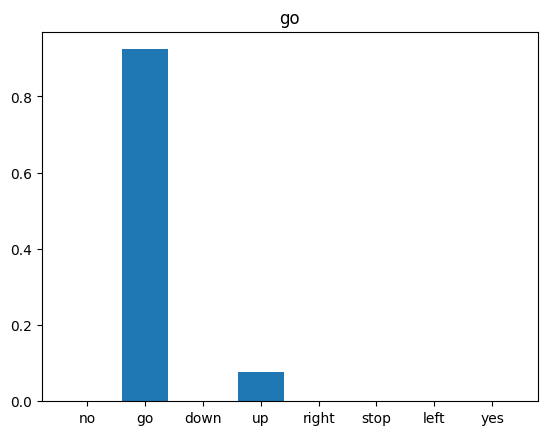

In [67]:
x ='/content/drive/MyDrive/PSV/mini_speech_commands/go/ffa76c4a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'go', 'down', 'up', 'right', 'stop', 'left', 'yes']

plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('go')
plt.show()

display.display(display.Audio(waveform, rate=16000))

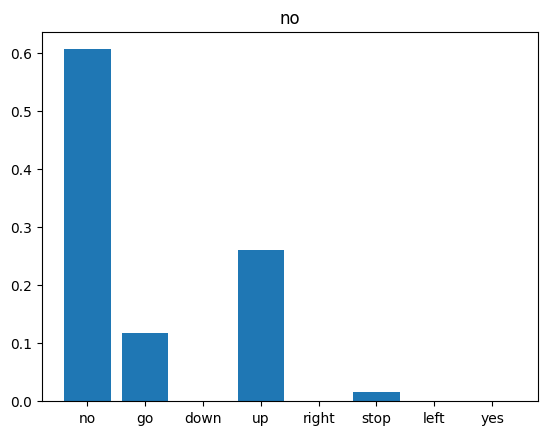

In [68]:
x ='/content/drive/MyDrive/PSV/mini_speech_commands/no/fafe8101_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'go', 'down', 'up', 'right', 'stop', 'left', 'yes']

plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('no')
plt.show()

display.display(display.Audio(waveform, rate=16000))

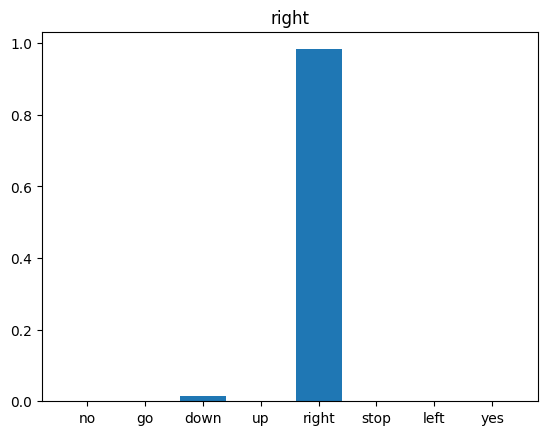

In [59]:
x ='/content/drive/MyDrive/PSV/mini_speech_commands/right/ffd2ba2f_nohash_4.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'go', 'down', 'up', 'right', 'stop', 'left', 'yes']

plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('right')
plt.show()

display.display(display.Audio(waveform, rate=16000))